In [76]:
# 1. 定义 Embeddings 词嵌入层
import torch
import torch.nn as nn
import math
from torch import dropout
# 1. 定义 Embeddings 词嵌入层

# init方法中定义了词表大小vocab_size和词向量维度d_model
# forward方法中输入x是一个二维张量，表示批次大小和序列长度 B L
# 通过nn.Embedding层将输入的词索引转换为对应的词向量，输出的embed_x形状为 B L D
# 最后将词向量乘以sqrt(d_model)进行缩放，以增强词向量的影响力

class Embeddings(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()

        self.vocab_size = vocab_size 
        self.d_model = d_model 

        self.embed = nn.Embedding(vocab_size, d_model) # embedding layer, look-up table

    def forward(self, x): # x: [batch_size, seq_len]
        # x.shape-->[batch_size, seq_len]-->[2, 4]
        # embed_x.shape-->[batch_size, seq_len, d_model]-->[2, 4, 512]
        embed_x = self.embed(x) # 在embedding层初始化的随机词表矩阵中 根据2个batch 和4个序列具体的索引 查找对应的512微词向量 并拼接
        # embed_x * sqrt(d_k) 1.符合标准正态分布 2.增强embedding词向量的影响
        return embed_x * math.sqrt(self.d_model)
    






In [77]:
# 2. 定义位置编码器层 （Positional Encoding）
# 位置编码器需要和 Embeddings 词嵌入层的结果相加，才能作为 Transformer 模型的输入

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=60): 
        # dropout_p: 随机失活的系数 
        # max_len：样本句子的最大长度 ，表明一次能处理文本的上限：seq_len<=max_len, max_len类似步长
        super().__init__()
        # 定义dropout层
        self.dropout = nn.Dropout(p=dropout)
        
        # 1. 初始化位置矩阵pe-->[max_len, d_model] 60*512
        pe = torch.zeros(max_len, d_model) # 初始化一个全0矩阵 60*512

        # 2. 定义位置列向量-->[max_len, 1]-->60*1   
        self.tem_vec = torch.arange(0, max_len).unsqueeze(1) #  在第1维增加一个维度 变成60*1

        # 3. 根据论文公式计算分母 pos/ (10000^(2i/d_model))   1*256
        self.div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)) # stride=2 

        # 4. 列向量X分母  60*1 X 1*256 = 60*256，利用三角函数实现位置编码 
        # 填充pe矩阵，奇数列，赋值sin曲线特征
        pe[:, 0::2] = torch.sin(self.tem_vec * self.div_term) 
        # 填充pe矩阵，偶数列，赋值cos曲线特征
        pe[:, 1::2] = torch.cos(self.tem_vec * self.div_term) 
        # 过程解析：按列遍历tem_vec * div_term， 计算出对应的sin和cos值，分别填充到pe矩阵的偶数列和奇数列中

        # 三角函数的好处： 1. 值域[-1,1]，模型训练稳定 2. 周期性变化，能很好地表示相对位置信息
        # 5. 注册pe  形状变化 [60,512]-->[1,60,512]
        pe = pe.unsqueeze(0) # 在第0维增加一个维度，变成1*60*512，方便后续和输入x相加
        # 把pe位置编码矩阵 注册成模型的持久缓冲区buffer; 模型保存再加载时，可以根模型参数一样，一同被加载
        # 什么是buffer: 对模型效果有帮助的，但是却不是模型结构中超参数或者参数，不参与模型训练
        self.register_buffer('pe', pe)

    def forward(self, x):
        # 注意：输入的x形状2*4*512  pe是1*60*512 形状 如何进行相加
        # 只需按照x的单词个数 进行切片即可(看成立方体)
        # 广播机制： 同时按维度遍历，{if同维度相等或其中一个维度为1时continue; else return error; }return true;
        position_x = x + self.pe[:,:x.size()[1]] 
        return self.dropout(position_x)





In [78]:
# 3. 自注意力机制函数attention 实现思路分析
# attention(query, key, value, mask=None, dropout=None)
# 1 求查询张量特征尺寸大小 d_k
# 2 求查询张量q的权重分布socres  q@k^T /math.sqrt(d_k)
# 形状[2,4,512] @ [2,512,4] --->[2,4,4]
# 3 是否对权重分布scores进行 scores.masked_fill(mask == 0, -1e9)
# 4 求查询张量q的权重分布 p_attn F.softmax()
# 5 是否对p_attn进行dropout if dropout is not None:
# 6 求查询张量q的注意力结果表示 [2,4,4]@[2,4,512] --->[2,4,512]
# 7 返回q的注意力结果表示 q的权重分布

from torch.autograd import Variable
import torch
import torch.nn as nn
import math
import copy
# from dm01_input.ipynb import * .py文件才能导包


def attention(query, key, value, mask=None, dropout=None):
    # query, key, value：代表注意力的三个输入张量
    # mask：代表掩码张量
    # dropout：传入的dropout实例化对象

    # 1 求查询张量特征尺寸大小
    dk = query.size()[-1]  # 根据query张量的最后一个维度，作为词嵌入的维度，也就是实际计算时词向量的维度

    # 2 求查询张量q的权重分布socres  q@k^T /math.sqrt(d_k)
    # [2,4,512] @ [2,512,4] --->[2,4,4]
    scores =  torch.matmul(query, key.transpose(-2, -1) ) / math.sqrt(dk)
   # 3 是否对权重分布scores 进行 masked_fill
    if mask is not None:
        # 根据mask矩阵0的位置 对sorces矩阵对应位置进行掩码
        scores = scores.masked_fill(mask == 0, -1e9)

    # 4 求查询张量q的权重分布 softmax
    attn = nn.Softmax(dim=-1)(scores)

    # 5 是否对p_attn进行dropout
    if dropout is not None:
        attn = dropout(attn)
    # 返回output O=AV 查询张量q的注意力结果表示 bmm-matmul运算, 注意力查询张量q的权重分布p_attn
    # [2,4,4]*[2,4,512] --->[2,4,512]
    output = torch.matmul(attn, value)
    return output, attn


In [79]:
# 测试 自注意力机制函数 attention
def dm_test_attention():

    d_model = 512   # 词嵌入维度是512维
    vocab = 1000    # 词表大小是1000

    # 输入x 是一个使用Variable封装的长整型张量, 形状是[batch_size=2 , seq_len=4]
    x = Variable(torch.LongTensor([[100, 2, 421, 508], [491, 998, 1, 221]]))
    my_embeddings =  Embeddings(vocab, d_model) # 词嵌入实例化对象
    x = my_embeddings(x) 
    # 打印词嵌入结果x
    print("打印词嵌入结果 x：input x--->", x.shape, '\n', x)  # torch.Size([2, 4, 512])

    dropout = 0.1   # 置0比率为0.1
    max_len = 60    # 句子最大长度

    my_pe = PositionalEncoding(d_model, dropout, max_len) # 位置编码实例化对象
    # 打印位置编码矩阵pe
    print("位置编码矩阵 pe--->", my_pe.pe.shape, '\n', my_pe.pe)  # torch.Size([1, 60, 512])
    pe_x = my_pe(x) # 通过调用位置编码对象的forward方法，给输入x增加位置编码信息
    # 打印位置编码结果pe_x
    print("位置编码结果 pe_x--->", pe_x.shape, '\n', pe_x)  # torch.Size([2, 4, 512])

    query = key = value = pe_x # torch.Size([2, 4, 512])  自注意力机制中，查询、键、值张量都相等 
    print("query/key/value--->", query.shape, '\n', query)
    output1, attn1 = attention(query, key, value)
    
    print('编码阶段 对注意力权重分布 不做掩码')
    print('注意力权重 attn1--->',attn1.shape, '\n', attn1)  # torch.Size([2, 4, 4])
    print('注意力表示结果 output1--->', output1.shape, '\n', output1)  # torch.Size([2, 4, 512])

    print('*' * 50)
    print('编码阶段 对注意力权重分布 做掩码')
    mask = Variable(torch.zeros(2, 4, 4))
    output2, attn2 = attention(query, key, value, mask=mask)
    print("注意力权重 attn2--->", attn2.shape, '\n', attn2)
    print("注意力表示结果 output2--->", output2.shape, '\n', output2)
# 调用dm_test_attention()
dm_test_attention()

打印词嵌入结果 x：input x---> torch.Size([2, 4, 512]) 
 tensor([[[  7.9453,  10.2181, -34.6902,  ..., -27.3373,  -0.6937, -28.2521],
         [-19.7746,   6.2054, -15.9668,  ...,  24.4773, -12.7136,  16.3630],
         [ 39.6240,  12.1394, -16.1446,  ..., -16.0391,  12.7031, -28.3768],
         [ 14.1253, -11.1596, -16.3081,  ..., -11.9837,  15.8359,   8.5877]],

        [[  6.3012, -33.3977,   1.9142,  ..., -36.2196,  -1.8037,   1.7991],
         [  4.7729, -28.1698,  34.7965,  ..., -12.8635,  -0.6413,  -7.0945],
         [ 22.8322, -27.6994, -46.7339,  ...,  11.0664,   7.9805, -12.3253],
         [ -5.4811, -19.9918, -11.1638,  ...,   3.7540,  15.4763,  42.0619]]],
       grad_fn=<MulBackward0>)
位置编码矩阵 pe---> torch.Size([1, 60, 512]) 
 tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
           1.0366e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  

In [80]:
# 4. 定义多头注意力机制层 MultiHeadedAttention

def clones(module, N):
    # module: 传入的模块对象
    # N: 需要复制的数量
    # 返回一个包含N个相同模块的ModuleList
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)]) # 列表生成式 深拷贝表示

class MultiHeadedAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        # embedding_dim: 词嵌入维度 d_model 512
        # num_heads: 注意力头数 8
        # dropout: 随机失活系数
        super().__init__()
        # 确保词嵌入维度能被头数整除 
        assert embedding_dim % num_heads == 0

        # 1.计算每个头的维度
        self.dk = embedding_dim // num_heads # 后续实际计算时词向量的维度 512/8=64

        self.num_heads = num_heads # 注意力头数 8

        # 2. 定义四个线性变换层（全连接层）  Q,K,V 和 最后输出的线性变换层 
        self.linear_layers = clones(nn.Linear(embedding_dim, embedding_dim), N=4)
        # self.linear_layers = nn.ModuleList([copy.deepcopy(nn.Linear(embedding_dim, embedding_dim)) for _ in range(4)])
        # 3. 定义dropout层
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        # query, key, value: 输入的查询、键、值张量 [2,4,512]
        # mask: 掩码张量 [num_heads, seq_len, seq_len]-->[8,4,4]
        if mask is not None:
            # 在掩码张量的第0维增加一个维度，方便后续和多头注意力机制的头数对应
            mask = mask.unsqueeze(0)  # [1, num_heads, seq_len, seq_len]-->[1,8,4,4]

        self.batch_size = query.size(0)  # 获取批次大小 2

        # q,k,v通过linear_layers进行线性变换, 再切分成多头形式
        # [2, 4, 512] --> [2, 4, 8, 64] --> [2, num_heads=8, seq_len=4, dk=64] 习惯性把seq_len和dk放在一起

        query, key, value = [model(x).view(self.batch_size, -1, self.num_heads, self.dk).transpose(1, 2) 
                             for model, x in zip(self.linear_layers, (query, key, value))] 
        # 转置是为了还原输入的形状，即[2, 8, 4, 64]
        # x是query,key,value
        # zip()函数用于将多个可迭代对象打包成一个元组列表，方便同时遍历
        # model是linear_layers中的线性变换层对象

        # 调用自注意力机制函数 attention() 实现多头注意力机制的计算
        # 形状 query/key/value: [2, 8, 4, 64]
        # mask: [1, 8, 4, 4]   广播机制
        # scores: [2, 8, 4, 4]     QKT/sqrt(dk)（使用mask）
        # attn: [2, 8, 4, 4]    A=softmax(scores)（使用dropout）
        # mha_output: [2, 8, 4, 64]    O=AV
        mha_output, _ = attention(query=query, key=key, value=value, mask=mask, dropout=self.dropout) # dropout不是forward的参数 而是类的属性

        # 将output进行拼接和线性变换
        # [2, 8, 4, 64] --> [2, 4, 512]
        # contiguous() 方法的作用是确保张量在内存中是连续存储的，这对于某些操作（如 view）是必要的
        # view() 方法用于改变张量的形状，而不改变其数据内容
        result = mha_output.transpose(1, 2).contiguous().view(self.batch_size, -1, self.num_heads * self.dk)
        
        return self.linear_layers[-1](result)  # 最后通过一个线性变换层 输出最终结果
        # 不同头在各自子空间学习到不同的注意力模式，简单拼接只是把这些子空间并列在一起。
        # 线性投影可以对拼接后的各头特征进行可学习的加权混合，融合跨头信息


In [81]:
# 测试 多头注意力机制层 MultiHeadedAttention

def dm_test_mha():

    d_model = 512   # 词嵌入维度是512维
    vocab = 1000    # 词表大小是1000

    # 输入x 是一个使用Variable封装的长整型张量, 形状是[batch_size=2 , seq_len=4]
    x = Variable(torch.LongTensor([[100, 2, 421, 508], [491, 998, 1, 221]]))
    my_embeddings =  Embeddings(vocab, d_model) # 词嵌入实例化对象
    x = my_embeddings(x) 
    # 打印词嵌入结果x
    #print("打印词嵌入结果 x：input x--->", x.shape, '\n', x)  # torch.Size([2, 4, 512])

    dropout = 0.1   # 置0比率为0.1
    max_len = 60    # 句子最大长度

    my_pe = PositionalEncoding(d_model, dropout, max_len) # 位置编码器实例化对象
    # 打印位置编码矩阵pe
    #print("位置编码矩阵 pe--->", my_pe.pe.shape, '\n', my_pe.pe)  # torch.Size([1, 60, 512])
    pe_x = my_pe(x) # 通过调用位置编码对象的forward方法，给输入x增加位置编码信息
    # 打印位置编码结果pe_x
    #print("位置编码结果 pe_x--->", pe_x.shape, '\n', pe_x)  # torch.Size([2, 4, 512])

    query = key = value = pe_x # torch.Size([2, 4, 512])  自注意力机制中，查询、键、值张量都相等 
    #print("query/key/value--->", query.shape, '\n', query)

    mha = MultiHeadedAttention(embedding_dim=512, num_heads=8, dropout=0.1)
    # 词嵌入[2,4,512]--->
    print(mha)
    output1 = mha(query, key, value)
    
    print('不做掩码')
    print('output1--->',output1.shape, '\n', output1)  # torch.Size([2, 4, 512])
    

    print('*' * 50)
    print('做掩码')
    mask = Variable(torch.zeros(8, 4, 4))
    output2 = mha(query, key, value, mask=mask)
    print("output2--->", output2.shape, '\n', output2) # torch.Size([2, 4, 512])

    return output2

# if __name__ == "__main__":
#     dm_test_mha()


In [82]:
c = None
if c:
    print("1.1")
if not c:
    print("1.2")
if c==None:
    print("2.1")
if c is None:
    print("2.2")
if c!=None:
    print("3.1")
if c is not None:
    print("3.2")



1.2
2.1
2.2


In [83]:
# 5. 前馈全连接层 FeedForwardNetwork

# 任务： 升维---> 非线性ReLU激活---> dropout层---> 降维
# init: 定义两个线性层和dropout层
# forward: 一行代码实现计算过程: output = self.Linear2(self.dropout(nn.ReLU()(self.Linear1(x))))
class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        # d_model: 词嵌入维度 512
        # d_ff: 前馈全连接层的隐藏层维度 2048，一般设置为d_model的4倍
        # dropout: 随机失活系数
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)  # 第一个线性变换层 升维
        self.linear2 = nn.Linear(d_ff, d_model)  # 第二个线性变换层 降维
        self.dropout = nn.Dropout(p=dropout)     # dropout层

    def forward(self, x):
        # x: 输入张量 [batch_size, seq_len, d_model] 来自多头注意力机制（第一个子层）的输出
        # 通过两个线性变换层和ReLU激活函数实现前馈全连接层的计算过程：
        # x = self.linear1(x)                      # 通过第一个线性变换层
        # x = nn.ReLU()(x)    !!ReLU()(x)          # 通过ReLU激活函数 作用：引入非线性，增强模型表达能力；防止过拟合；升维再降维，在高维空间计算更好地捕捉复杂特征
        # x = self.dropout(x)                      # 通过dropout层
        # x = self.linear2(x)                      # 通过第二个线性变换层
        # return x                                 # 返回前馈全连接层的输出
        # 以上代码等价于下面一行代码
        return self.linear2(self.dropout(nn.ReLU()(self.linear1(x))))

 # 测试 前馈全连接层 FeedForwardNetwork
def dm_test_ffn():

    attn_output = dm_test_mha()
    print("attn_output--->", attn_output.shape, '\n', attn_output) # torch.Size([2, 4, 512])

    ffn = FeedForwardNetwork(d_model=512, d_ff=2048, dropout=0.1)
    ffn_output = ffn(attn_output)
    print("ffn_output--->", ffn_output.shape, '\n', ffn_output) # torch.Size([2, 4, 512])
    return ffn_output

# if __name__ == "__main__":
#     dm_test_ffn()


6. 规范化层的作用：
* 它是所有深层网络模型都需要的标准网络层，因为随着网络层数的增加，通过多层的计算后参数可能开始出现过大或过小的情况，这样可能会导致学习过程出现异常，模型可能收敛非常的慢. 因此都会在一定层数后接规范化层进行数值的规范化，使其特征数值在合理范围内.  

* 常见的规范化层种类：  *例如在一个 样本 X 特征 的矩阵中* 
  1. batch_norm : 针对同一个特征的不同样本进行规范化，按列规范化，一般用于处理图片
  2. layer_norm : 针对同一个样本的不同特征进行规范化，按行规范化，一般用于处理文本；且nlp过程中，一般文本是不等长的，无法按列处理

* 广播(Broadcasting)规则如下：

  1. 如果两个张量的维度数量不同，PyTorch 会自动在左侧补 1

  2. 然后从右往左比较维度：

    - 两个维度相等 可以广播

    - 某个维度是 1 可以广播

    - 否则无法广播

In [84]:
# 6. Norm 层 （规范化层）

# 规范化层 LayerNorm 实现思路分析
# 1 init函数  (self, features, eps=1e-6):
   # 定义线性层self.a2 self.b2, nn.Parameter(torch.ones(features))
   
# 2 forward(self, x) 返回标准化后的结果
    # 对数据求均值 保持形状不变 x.mean(-1, keepdims=True)
    # 对数据求方差 保持形状不变 x.std(-1, keepdims=True)
    # 对数据进行标准化变换 反向传播可学习参数a2 b2 
    # eg self.a2 * (x-mean)/(std + self.eps) + self.b2
    # 本质就是用两个行向量，通过PyTorch广播机制，自动加维，并扩展到和输入张量x形状一致，然后进行标准化变换的缩放和平移，简化代码

class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        # features: 输入张量的最后一个维度大小, 即词嵌入维度 d_model 512
        # eps: 防止分母为零的较小常数
        super().__init__()
        # a2 和 b2 分别是y = kx + b中的k和b，是可学习的参数（
        # 加上了nn.Parameter,很多其他方法里面也封装了nn.Parameter, 比如nn.Embedding, nn.Linear等
        self.a2 = nn.Parameter(torch.ones(features))  # 可学习的缩放参数 one表示初始化为1 shape=512
        self.b2 = nn.Parameter(torch.zeros(features)) # 可学习的平移参数 
        self.eps = eps
    def forward(self, x): 
        # x: 输入张量 [batch_size, seq_len, d_model]  [2, 4, 512]
        mean = x.mean(-1, keepdim=True)  # 计算均值，保持形状不变 mean(-1)表示对最后一个维度求均值 [2,4,1]
        std = x.std(-1, keepdim=True)    # 计算标准差，保持形状不变 std(-1)表示对最后一个维度求标准差 [2,4,1]
        # 标准化变换
        y = self.a2 * (x - mean) / (std + self.eps) + self.b2 
        # 广播机制 [2,4,512]
        # a2 b2 都是512维的行向量，通过广播机制扩展到[2,4,512]，与x的形状匹配
        return y 
    
# 测试 规范化层 LayerNorm
def dm_test_layernorm():

    ffn_output = dm_test_ffn()
    print("ffn_output--->", ffn_output.shape, '\n', ffn_output) # torch.Size([2, 4, 512])

    layernorm = LayerNorm(features=512, eps=1e-6) # 词嵌入维度512 features = d_model
    norm_output = layernorm(ffn_output)
    print("norm_output--->", norm_output.shape, '\n', norm_output) # torch.Size([2, 4, 512])
    return norm_output

# if __name__ == "__main__":
#     dm_test_layernorm()

7. 子层连接结构 add层 残差连接并 将 多头注意力层 或 前馈全连接层 与 add&norm层 结合起来 形成一个子层  

*输入到每个子层(mha层和ffn层)以及规范化层(LayerNorm)的过程中，还使用了残差链接（跳跃连接），因此我们把这一部分结构整体叫做子层连接（代表子层及其链接结构），在每个编码器层中，都有两个子层，这两个子层加上周围的链接结构就形成了两个子层连接结构.*

In [85]:
# 7. 子层连接结构 add层 残差连接并 将 多头注意力层 或 前馈全连接层 与 add&norm层 结合起来 形成一个子层
# 本质就是调用进入子层前的输入x, 然后x经过LayerNorm规范化层, 
# 再进入子层sublayer(多头注意力机制层 或 前馈全连接层)计算，
# 再经过dropout层，最后和进入当前子层前的 输入x 进行残差连接(add) 并返回结果
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        # size: 词嵌入维度 d_model 512
        # dropout: 随机失活系数
        super().__init__()
        self.norm = LayerNorm(features=size)  # 规范化层实例化对象
        self.dropout = nn.Dropout(p=dropout)  # dropout层实例化对象

    # def forward(self, x, sublayer):
    #     # x: 输入张量 [batch_size, seq_len, d_model]  [2, 4, 512]
    #     # sublayer: 子层函数（多头注意力机制层: x 表示原始输入 或前馈全连接层：x代表第一层输出结果）
    #     # sublayer代表一个函数对象或者全连接层对象
    #     # 1. 对输入x进行规范化
    #     norm_x = self.norm(x)
    #     # 2. 将规范化后的结果传入子层函数进行计算
    #     sublayer_output = sublayer(norm_x)
    #     # 3. 对子层输出结果进行dropout处理
    #     dropped_output = self.dropout(sublayer_output)
    #     # 4. 将dropout后的结果与输入x进行残差连接并返回
    #     return x + dropped_output
    def forward(self, x, sublayer):
        # 参数x 代表传进子层的数据
        # sublayer 函数入口地址 子层函数(前馈全连接层 或者 注意力机制层函数的入口地址)
        # 方式1 pre-norm # 数据self.norm() -> sublayer()->self.dropout() + x 
        myres = x + self.dropout(sublayer(self.norm(x)))
        # 方式2 post-norm # 数据sublayer() -> self.norm() ->self.dropout() + x 
        # myres = x + self.dropout(self.norm(x.subtype(x)))
        return myres

* 8. 编码器层的作用：作为编码器的组成单元, 每个编码器层完成一次对输入的特征提取过程, 即编码过程.
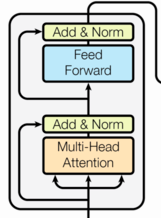



In [ ]:
# 8. 编码器层
# task: 完成当前第N个编码器层的所有前向计算过程（两个子层连接结构的计算过程）
# 编码器层类 EncoderLayer 实现思路分析
# init函数 (self, size, self_attn, feed_forward, dropout):
    # 实例化多头注意力层对象self_attn 
    # 前馈全连接层对象feed_forward  
    # size词嵌入维度512
    # clones两个子层连接结构 self.sublayer = clones(SublayerConnection(size,dropout),2)
# forward函数 (self, x, mask)
    # 数据经过子层连接结构1 self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
    # 数据经过子层连接结构2 self.sublayer[1](x, self.feed_forward)
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout=0.1):
        # size: 词嵌入维度 d_model 512
        # self_attn: 多头注意力机制层对象
        # feed_forward: 前馈全连接层对象
        # dropout: 随机失活系数
        super().__init__()
        self.self_attn = self_attn  # 多头注意力机制层对象
        self.feed_forward = feed_forward  # 前馈全连接层对象
        self.sublayer = clones(SublayerConnection(size, dropout), 2)  # 克隆两个子层连接结构
        self.size = size  # 词嵌入维度

    def forward(self, x, mask):
        # x: 输入张量 [batch_size, seq_len, d_model]  [2, 4, 512]
        # mask: 掩码张量 [num_heads, seq_len, seq_len]-->[8,4,4]
        # 数据经过子层连接结构1
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # 数据经过子层连接结构2
        encoder_layer_output = self.sublayer[1](x, self.feed_forward)
        return encoder_layer_output # 返回当前编码器层的输出，作为下一个编码器层或norm层的输入

❓ self.sublayer[1](x, self.feed_forward) 做了什么？

等价于：

SublayerConnection.forward(self.sublayer[1], x, self.feed_forward)


也就是：

1. 调用sublayer1的forward方法，传入x和self.feed_forward（用feed_forward替换SublayerConnection.forward中的sublayer参数）
2. 在SublayerConnection的forward方法中，先对x进行LayerNorm规范化
3. 然后将规范化后的结果传入self.feed_forward函数进行前馈计算
4. 最后将前馈的结果与原始输入x相加，形成残差连接的输出
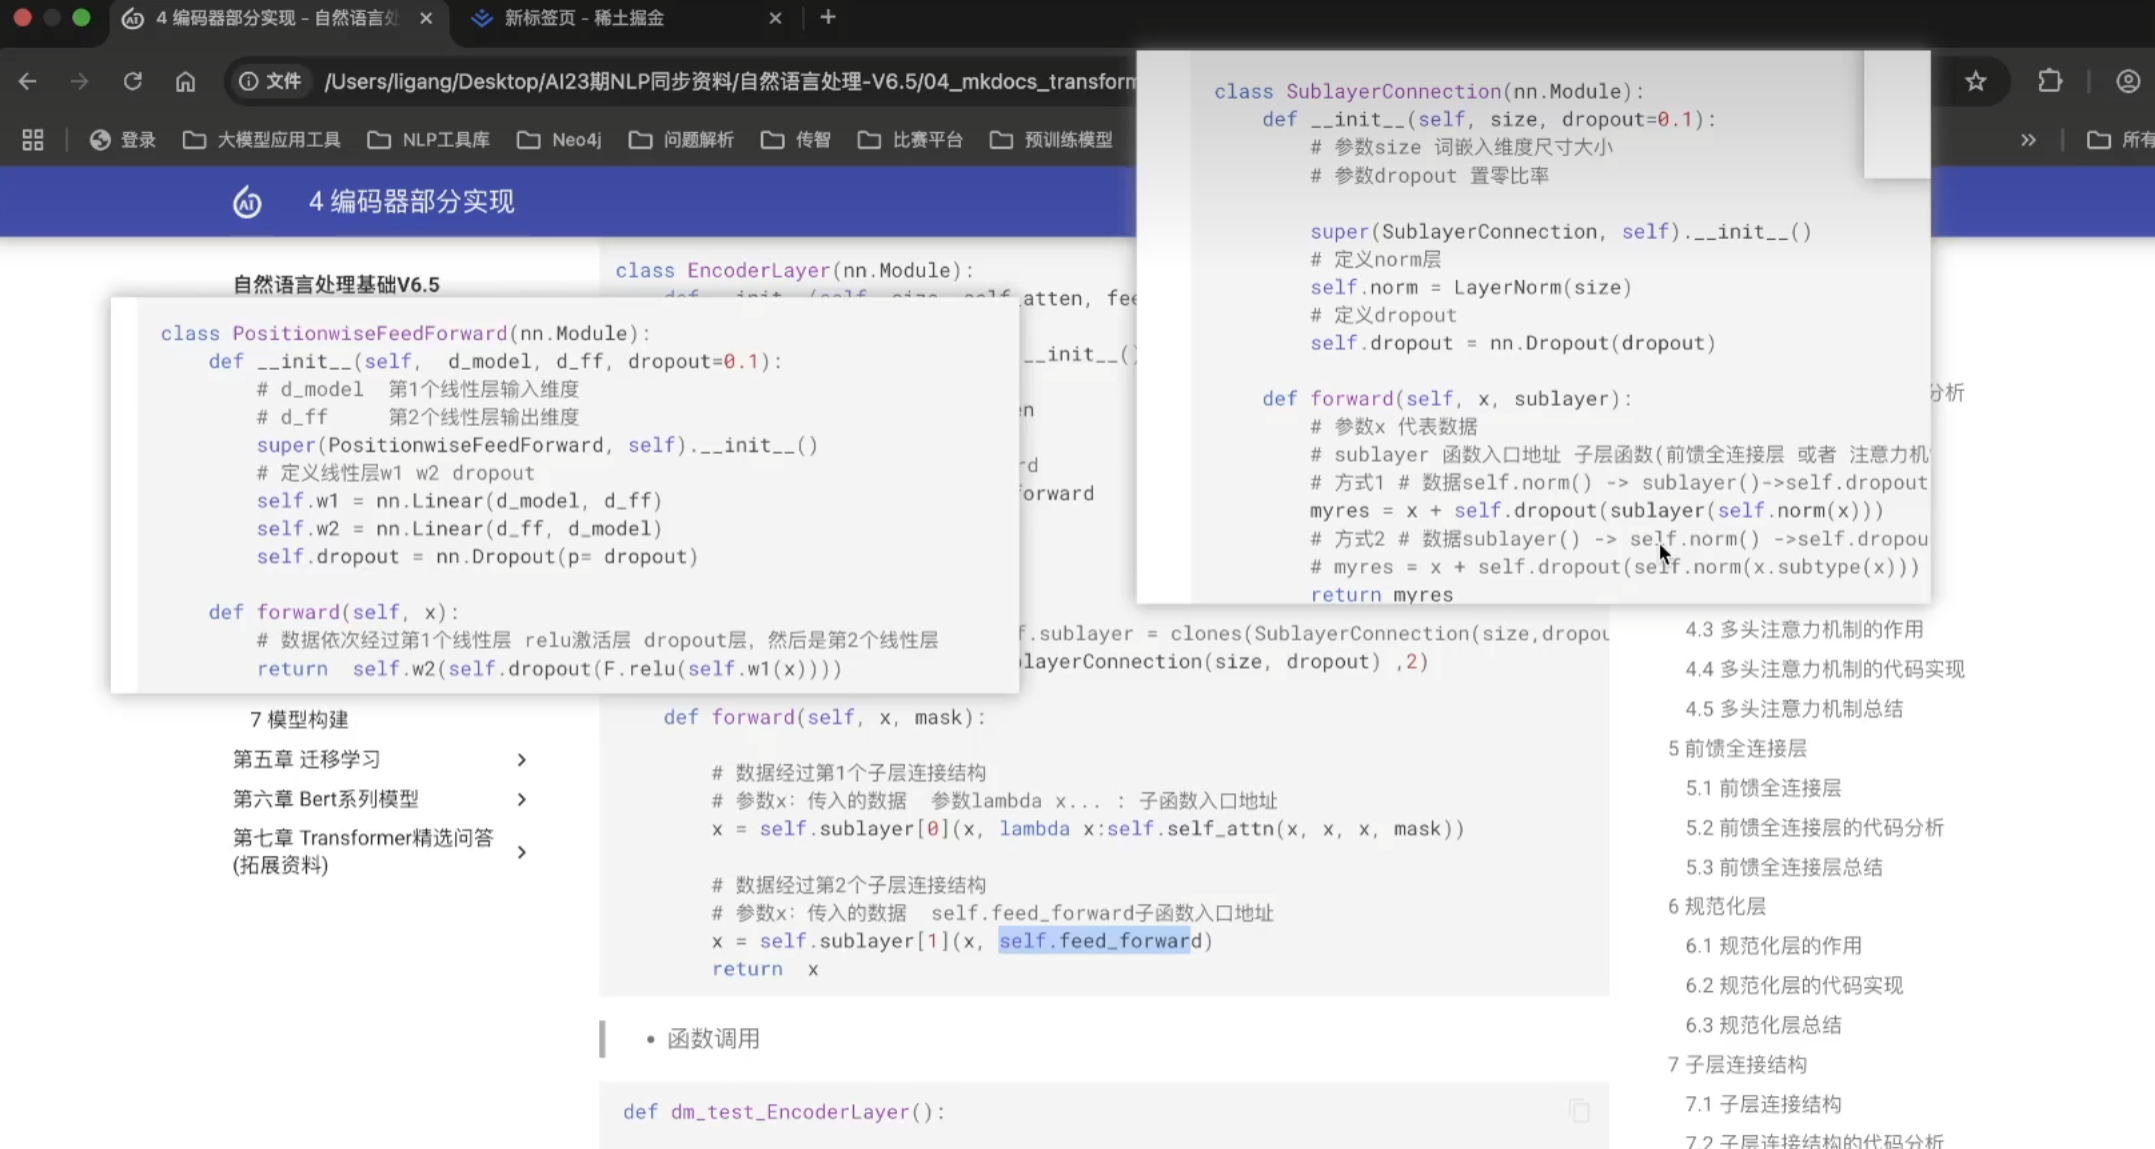

In [87]:
# 9. 编码器Encoder (没有层)
# 任务：循环调用N个编码器层对象，完成整个编码器的N层前向计算过程
# 编码器类 Encoder 实现思路分析
# init函数 (self, layer, N):
    # layer: 编码器!层!对象
    # 克隆N个编码器层 self.layers = clones(layer, N)
    # 定义规范化层 self.norm = LayerNorm(layer.size)
# forward函数 (self, x, mask):
    # 循环调用N个编码器层对象进行前向计算
    # 最后对输出结果进行规范化处理并返回
class Encoder(nn.Module):
    def __init__(self, layer, N):
        # layer: 编码器层对象
        # N: 编码器层数
        super().__init__()
        self.layers = clones(layer, N)  # 克隆N个编码器层   
        self.layerNorm = LayerNorm(features=layer.size)  # 规范化层 size:词嵌入维度512

    def forward(self, x, mask):
        # x: 输入张量 [batch_size, seq_len, d_model]  [2, 4, 512]
        # mask: 掩码张量 [num_heads, seq_len, seq_len]-->[8,4,4]
        # 循环调用N个编码器层对象进行前向计算
        for layer in self.layers:
            x = layer(x, mask)
        # 对最终输出结果进行规范化处理并返回
        encoder_output = self.layerNorm(x)
        # 之后就可以送给后续的解码器了
        return encoder_output




In [88]:
# tset encoder
def dm_test_encoder():

    d_model = 512   # 词嵌入维度是512维
    vocab = 1000    # 词表大小是1000

    # 输入x 是一个使用Variable封装的长整型张量, 形状是[batch_size=2 , seq_len=4]
    x = Variable(torch.LongTensor([[100, 2, 421, 508], [491, 998, 1, 221]]))
    my_embeddings =  Embeddings(vocab, d_model) # 词嵌入实例化对象
    x = my_embeddings(x) 
    # 打印词嵌入结果x
    #print("打印词嵌入结果 x：input x--->", x.shape, '\n', x)  # torch.Size([2, 4, 512])

    dropout = 0.1   # 置0比率为0.1
    max_len = 60    # 句子最大长度

    my_pe = PositionalEncoding(d_model, dropout, max_len) # 位置编码器实例化对象
    # 打印位置编码矩阵pe
    print("位置编码矩阵 pe--->", my_pe.pe.shape, '\n', my_pe.pe)  # torch.Size([1, 60, 512])
    pe_x = my_pe(x) # 通过调用位置编码对象的forward方法，给输入x增加位置编码信息
    # 打印位置编码结果pe_x
    print("位置编码结果 pe_x--->", pe_x.shape, '\n', pe_x)  # torch.Size([2, 4, 512])

    query = key = value = pe_x # torch.Size([2, 4, 512])  自注意力机制中，查询、键、值张量都相等 
    print("query/key/value--->", query.shape, '\n', query)
    # 实例化各个子层对象
    # 多头注意力机制层对象 MultiHeadedAttention
    mha = MultiHeadedAttention(embedding_dim=512, num_heads=8, dropout=0.1)
    # 前馈全连接层对象 FeedForwardNetwork
    ffn = FeedForwardNetwork(d_model=512, d_ff=2048, dropout=0.1)
    # 编码器层对象 EncoderLayer
    encoder_layer = EncoderLayer(size=512, self_attn=mha, feed_forward=ffn, dropout=0.1)
    # 编码器对象 Encoder 
    encoder = Encoder(layer=encoder_layer, N=6) # 6层编码器层
    # 打印编码器结构
    print("编码器结构--->", encoder) 
    encoder_output = encoder(query, mask=None) 
    print('编码器输出 encoder_output--->',encoder_output.shape, '\n', encoder_output)  # torch.Size([2, 4, 512])

# if __name__ == "__main__":
#     dm_test_encoder()

# 10. 解码器层
解码器由N个解码器层堆叠而成
每个解码器层由三个子层连接结构组成
第一个子层连接结构包括一个多头自注意力子层和规范化层以及一个残差连接
第二个子层连接结构包括一个多头注意力子层和规范化层以及一个残差连接
第三个子层连接结构包括一个前馈全连接子层和规范化层以及一个残差连接
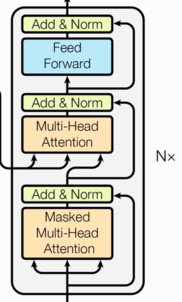

说明:
解码器层中的各个部分，如，多头注意力机制，规范化层，前馈全连接网络，子层连接结构都与编码器中的实现相同. 因此这里可以直接拿来构建解码器层.
2 解码器层
2.1 解码器层的作用
作为解码器的组成单元, 每个解码器层根据给定的输入向目标方向进行特征提取操作，即解码过程.

In [89]:
# 10. 解码器层
# 任务：完成当前第N个解码器层的所有前向计算过程（两个子层连接结构和一个掩码子层连接结构的计算过程）
# 解码器层类 DecoderLayer 实现思路分析
# init函数 (self, size, self_attn, src_attn, feed_forward, dropout):
    # 实例化多头！自！注意力层对象self_attn 
    # 实例化多头注意力层对象src_attn
    # 实例化前馈全连接层对象feed_forward  size词嵌入维度512
    # clones三个子层连接结构 self.sublayer = clones(SublayerConnection(size,dropout),3)
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout=0.1):
        super().__init__()
        self.size = size  # 词嵌入维度
        self.self_attn = self_attn  # 多头自注意力机制层对象
        self.src_attn = src_attn    # 多头注意力机制层对象
        self.feed_forward = feed_forward  # 前馈全连接层对象
        self.sublayer = clones(SublayerConnection(size, dropout), 3)  # 克隆三个子层连接器对象 size是词嵌入维度512
    def forward(self, y, encoder_output, src_mask, sentence_mask):
        # y: decoder的输入张量 [batch_size, seq_len, d_model]  [2, 4, 512]
        # encoder_output: 来自编码器的输出张量 [batch_size, seq_len, d_model]  [2, 4, 512]
        # src_mask:      作用在第二个子层的多头注意力机制对象上的掩码张量 进行padding_mask [num_heads, seq_len, seq_len]-->[8,4,4]
        # sentence_mask: 作用在第一个子层的多头！自！注意力机制对象上的掩码张量 进行sentence_mask (casual mask) [num_heads, seq_len, seq_len]-->[8,4,4]
        # y经过第一个子层 多头self注意力机制层
        y1 = self.sublayer[0](y, lambda y: self.self_attn(y, y, y, sentence_mask))
        # y经过第二个子层 多头cross注意力机制层
        y2 = self.sublayer[1](y1, lambda y1: self.src_attn(y1, encoder_output, encoder_output, src_mask))
        # y经过第三个子层 前馈全连接层
        decoder_layer_output = self.sublayer[2](y2, self.feed_forward)   
        # 返回当前解码器层的输出结果，传递给下一个解码器层或softmax层
        return decoder_layer_output
        


In [ ]:
# 11. 解码器Decoder (没有层)
# 任务：循环调用N个解码器层对象，完成整个解码器的N层前向计算过程
# 解码器类 Decoder 实现思路分析
# init函数 (self, layer, N):
    # layer: 解码器!层!对象
    # 克隆N个解码器层 self.layers = clones(layer, N)
    # 定义规范化层 self.norm = LayerNorm(layer.size)
# forward函数 (self, x, encoder_output, src_mask, sentence_mask):
    # 循环调用N个解码器层对象进行前向计算   
    # 最后对输出结果进行规范化处理并返回
class Decoder(nn.Module):
    def __init__(self, layer, N):
        # layer: 解码器层对象
        # N: 解码器层数
        super().__init__()
        self.layers = clones(layer, N)  # 克隆N个解码器层   
        self.layerNorm = LayerNorm(features=layer.size)  # 规范化层 size:词嵌入维度512

    def forward(self, y, encoder_output, src_mask, sentence_mask):
        # y: 输入张量 [batch_size, seq_len, d_model]  [2, 4, 512]
        # encoder_output: 来自编码器的输出张量 [batch_size, seq_len, d_model]  [2, 4, 512]
        for layer in self.layers:
            y = layer(y, encoder_output, src_mask, sentence_mask) 
        # 对最终输出结果进行规范化处理并返回
        decoder_output = self.layerNorm(y)
        # 之后就可以送给后续的线性变换层和softmax层了
        return decoder_output # torch.Size([2, 4, 512])

In [ ]:
# test decoder 解码器

def dm_test_decoder():

    d_model = 512   # 词嵌入维度是512维
    vocab = 1000    # 词表大小是1000

    # 输入x 是一个使用Variable封装的长整型张量, 形状是[batch_size=2 , seq_len=4]
    x = Variable(torch.LongTensor([[100, 2, 421, 508], [491, 998, 1, 221]]))
    my_embeddings =  Embeddings(vocab, d_model) # 词嵌入实例化对象
    x = my_embeddings(x) 
    # 打印词嵌入结果x
    #print("打印词嵌入结果 x：input x--->", x.shape, '\n', x)  # torch.Size([2, 4, 512])

    dropout = 0.1   # 置0比率为0.1
    max_len = 60    # 句子最大长度

    my_pe = PositionalEncoding(d_model, dropout, max_len) # 位置编码器实例化对象
    # 打印位置编码矩阵pe
    print("位置编码矩阵 pe--->", my_pe.pe.shape, '\n', my_pe.pe)  # torch.Size([1, 60, 512])
    pe_x = my_pe(x) # 通过调用位置编码对象的forward方法，给输入x增加位置编码信息
    # 打印位置编码结果pe_x
    print("位置编码结果 pe_x--->", pe_x.shape, '\n', pe_x)  # torch.Size([2, 4, 512])

    query = key = value = pe_x # torch.Size([2, 4, 512])  自注意力机制中，查询、键、值张量都相等 
    print("query/key/value--->", query.shape, '\n', query)
    # 实例化各个子层对象
    # 多头注意力机制层对象 MultiHeadedAttention
    mha = MultiHeadedAttention(embedding_dim=512, num_heads=8, dropout=0.1)
    # 前馈全连接层对象 FeedForwardNetwork
    ffn = FeedForwardNetwork(d_model=512, d_ff=2048, dropout=0.1)
    # 编码器层对象 EncoderLayer
    encoder_layer = EncoderLayer(size=512, self_attn=mha, feed_forward=ffn, dropout=0.1)
    # 编码器对象 Encoder 
    encoder = Encoder(layer=encoder_layer, N=6) # 6层编码器层
    # 打印编码器结构
    print("编码器结构--->", encoder) 
    encoder_output = encoder(query, mask=None) 
    print('编码器输出 encoder_output--->',encoder_output.shape, '\n', encoder_output)  # torch.Size([2, 4, 512])
    # 解码器层对象 DecoderLayer
    decoder_layer = DecoderLayer(size=512, self_attn=mha, src_attn=mha, feed_forward=ffn, dropout=0.1)

    # 解码器对象 Decoder
    decoder = Decoder(layer=decoder_layer, N=6)  # 6层解码器层
    # 打印解码器结构
    print("解码器结构--->", decoder)
    decoder_output = decoder(y=query, encoder_output=encoder_output, src_mask=None, sentence_mask=None)
    print('解码器输出 decoder_output--->', decoder_output.shape, '\n', decoder_output)  # torch.Size([2, 4, 512])

# if __name__ == "__main__":
#     dm_test_decoder()


位置编码矩阵 pe---> torch.Size([1, 60, 512]) 
 tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
           1.0366e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
           2.0733e-04,  1.0000e+00],
         ...,
         [ 4.3616e-01,  8.9987e-01, -9.9997e-01,  ...,  9.9998e-01,
           5.9088e-03,  9.9998e-01],
         [ 9.9287e-01,  1.1918e-01, -5.6324e-01,  ...,  9.9998e-01,
           6.0124e-03,  9.9998e-01],
         [ 6.3674e-01, -7.7108e-01,  3.5823e-01,  ...,  9.9998e-01,
           6.1161e-03,  9.9998e-01]]])
位置编码结果 pe_x---> torch.Size([2, 4, 512]) 
 tensor([[[ 31.2746,   0.0000, -56.9748,  ...,  -8.9690,  23.2616,  -8.5210],
         [ 17.7688,  -0.0000,   1.7448,  ...,   7.4198, -10.3431, -10.8299],
         [  8.2999,  -4.0761,   0.1430,  ...,  -0.0000,  16.8654,  17.6979],
         [ 11.3838,  -1.0104,  -9.9437, 

编码器结构---> Encoder(
  (layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadedAttention(
        (linear_layers): ModuleList(
          (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForwardNetwork(
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (sublayer): ModuleList(
        (0-1): 2 x SublayerConnection(
          (norm): LayerNorm()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (layerNorm): LayerNorm()
)
编码器输出 encoder_output---> torch.Size([2, 4, 512]) 
 tensor([[[ 1.1200e+00, -1.8197e-01, -2.4504e+00,  ..., -4.5670e-01,
           6.5278e-01, -3.2396e-01],
         [ 6.0313e-01, -2.9576e-02, -1.9415e-01,  ...,  2.2171e-01,
          -6.6110e-01, -6.3503e-0

In [ ]:
# 12. 输出层Generator 生成器 （线性层 + Softmax层）
# 任务：将解码器的输出转换为词表大小的概率分布
class Generator(nn.Module):
    def __init__(self, d_model, vocab_size):
        # d_model: 词嵌入维度 512
        # vocab_size: 词表大小 1000
        super().__init__()
        self.project = nn.Linear(d_model, vocab_size)  # 线性变换层

    def forward(self, x):
        # x: 输入张量 [batch_size, seq_len, d_model]  [2, 4, 512]
        # 通过线性变换层将d_model维度映射到词表大小vocab_size
        logits = self.project(x)  # [batch_size, seq_len, vocab_size]  [2, 4, 1000]
        # 对每个位置的词向量进行softmax操作，得到词表大小的概率分布
        prob_distribution = nn.LogSoftmax(dim=-1)(logits)  # 在最后一个维度上进行softmax 
        return prob_distribution  # 返回词表大小的概率分布

In [95]:
# test generator
def dm_test_generator():
    # 第一阶段：准备输入数据
    print('*' * 20 + '第一阶段：准备输入数据' + '*' * 20)

    d_model = 512   # 词嵌入维度是512维
    vocab = 1000    # 词表大小是1000

    # 输入x 是一个使用Variable封装的长整型张量, 形状是[batch_size=2 , seq_len=4]
    x = Variable(torch.LongTensor([[100, 2, 421, 508], [491, 998, 1, 221]]))
    my_embeddings =  Embeddings(vocab, d_model) # 词嵌入实例化对象
    x = my_embeddings(x) 
    # 打印词嵌入结果x
    print("打印词嵌入结果 x：input x--->", x.shape, '\n', x)  # torch.Size([2, 4, 512])

    dropout = 0.1   # 置0比率为0.1
    max_len = 60    # 句子最大长度

    my_pe = PositionalEncoding(d_model, dropout, max_len) # 位置编码器实例化对象
    # 打印位置编码矩阵pe
    print("位置编码矩阵 pe--->", my_pe.pe.shape, '\n', my_pe.pe)  # torch.Size([1, 60, 512])
    pe_x = my_pe(x) # 通过调用位置编码对象的forward方法，给输入x增加位置编码信息
    # 打印位置编码结果pe_x
    print("位置编码结果 pe_x--->", pe_x.shape, '\n', pe_x)  # torch.Size([2, 4, 512])

    query = key = value = pe_x # torch.Size([2, 4, 512])  自注意力机制中，查询、键、值张量都相等 
    print("query/key/value--->", query.shape, '\n', query)



    # 第二阶段：输入进入transformer编码器
    print('*' * 20 + '第二阶段：输入进入transformer编码器' + '*' * 20)
    # 实例化各个子层对象
    # 多头注意力机制层对象 MultiHeadedAttention
        # 注意实例化一个mha就行，mha的输入参数有三个，会在layer层传入不同的query,key,value
        # 在encoder_layer中传入三个相等的query,key,value，实现自注意力机制
        # 在decoder_layer中，传入query,以及encoder最后的输出作为key,value，实现交叉注意力机制
    mha = MultiHeadedAttention(embedding_dim=512, num_heads=8, dropout=0.1)
    # 前馈全连接层对象 FeedForwardNetwork
    ffn = FeedForwardNetwork(d_model=512, d_ff=2048, dropout=0.1)
    # 编码器层对象 EncoderLayer
    encoder_layer = EncoderLayer(size=512, self_attn=mha, feed_forward=ffn, dropout=0.1)
    # 编码器对象 Encoder
    encoder = Encoder(layer=encoder_layer, N=6) # 6层编码器层
    # 打印编码器结构
    print("编码器结构--->", encoder)
    encoder_output = encoder(query, mask=None) 
    print('编码器输出 encoder_output--->',encoder_output.shape, '\n', encoder_output)  # torch.Size([2, 4, 512])

    # 第三阶段：输入进入transformer解码器
    print('*' * 20 + '第三阶段：输入进入transformer解码器' + '*' * 20)
    # 解码器层对象 DecoderLayer
    decoder_layer = DecoderLayer(size=512, self_attn=mha, src_attn=mha, feed_forward=ffn, dropout=0.1)
    # 解码器对象 Decoder
    decoder = Decoder(layer=decoder_layer, N=6)  # 6层解码器层
    # 打印解码器结构
    print("解码器结构--->", decoder)    
    decoder_output = decoder(y=query, encoder_output=encoder_output, src_mask=None, sentence_mask=None)
    print('解码器输出 decoder_output--->', decoder_output.shape, '\n', decoder_output)  # torch.Size([2, 4, 512])

    # 第四阶段：解码器输出进入生成器Generator
    print('*' * 20 + '第四阶段：解码器输出进入生成器' + '*' * 20)
    generator = Generator(d_model=512, vocab_size=1000) # 实例化生成器对象
    prob_distribution = generator(decoder_output) # shape: [2, 4, 1]
    print('生成器输出 prob_distribution--->', prob_distribution.shape, '\n', prob_distribution)  # torch.Size([2, 4, 1000])

if __name__ == "__main__":
    dm_test_generator()
    


********************第一阶段：准备输入数据********************
打印词嵌入结果 x：input x---> torch.Size([2, 4, 512]) 
 tensor([[[  7.4079,  26.2955, -17.4642,  ...,  15.1654,   9.5196, -21.4338],
         [ 11.5802,   8.4394, -16.3637,  ...,   7.7591, -43.5026,  14.5165],
         [-15.3673,  -0.1696,   1.2967,  ...,   1.3776, -33.4499,  27.5396],
         [-49.7197,  -0.5662,  -0.4483,  ...,  11.3694,  -5.4902, -25.1298]],

        [[-19.5277,  32.0755,   4.5673,  ...,  83.7930,   9.0461,  -3.2820],
         [  9.1811,  11.6625,  26.7471,  ...,  11.7663, -20.8607, -14.5645],
         [ 14.5901,   0.6700,  18.0240,  ..., -17.8854, -20.7268,  27.9030],
         [ -4.2598,  12.1645,  11.7544,  ..., -16.7947,  40.0596,  26.2672]]],
       grad_fn=<MulBackward0>)
位置编码矩阵 pe---> torch.Size([1, 60, 512]) 
 tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
           1.0366e-04,  1.0000e+00]